<a href="https://colab.research.google.com/github/fambargh/evaluate/blob/master/segmentation_for_differ_backbone_c2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-lq983he6
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-lq983he6
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=dcee53d74f9efbc8ea099e7b9567ee0358196f4c44791ae9964b5a280b96277e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_bwgg8ma/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [2]:
# Install required libs
!pip install -U --pre segmentation-models --user

Requirement already up-to-date: segmentation-models in /root/.local/lib/python3.6/site-packages (1.0.1)


In [4]:
from zipfile import ZipFile
filename = "approach2.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [5]:
from zipfile import ZipFile
filename = "test_approach.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train_dir = '/content/image_train/'
y_train_dir = '/content/a2_cup_train/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/a2_cup_valid/'

x_test_dir = '/content/test_i_d/'
y_test_dir = '/content/test_c2_d/'

In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """ Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'oc','nolabeled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. oc)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

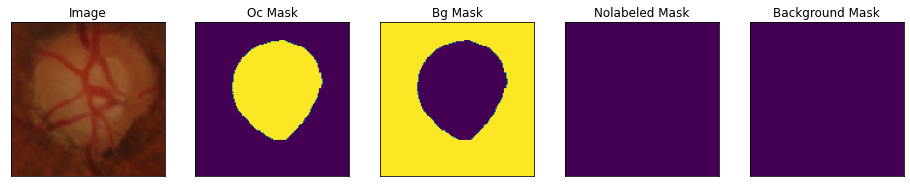

In [6]:
# Lets look at data we have
dataset = Dataset(x_test_dir, y_test_dir, classes=['oc','bg','nolabeled'])
image, mask = dataset[12] # get some sample
#cv2.imwrite('/content/result/0.png',image)
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
    )

In [0]:
import albumentations as A


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        #A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=20, p=1),
                A.MotionBlur(blur_limit=20, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(224, 224)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

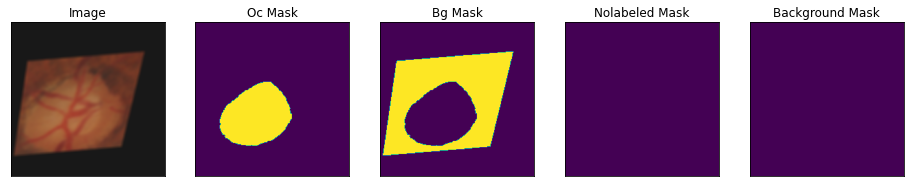

In [9]:
# Lets look at augmented data we have
dataset = Dataset(x_test_dir, y_test_dir, classes=['oc', 'bg','nolabeled'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    nolabeled_mask=mask[..., 2].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

In [10]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


Epoch 1/200
91/91 [==============================] - 17s 182ms/step - loss: 0.9421 - iou_score: 0.2374 - f1-score: 0.3404 - precision: 0.2638 - recall: 0.7921 - val_loss: 1.1011 - val_iou_score: 0.1445 - val_f1-score: 0.2293 - val_precision: 0.1496 - val_recall: 0.8668
Epoch 2/200
91/91 [==============================] - 6s 70ms/step - loss: 0.8509 - iou_score: 0.3818 - f1-score: 0.5035 - precision: 0.4255 - recall: 0.8604 - val_loss: 1.0584 - val_iou_score: 0.2159 - val_f1-score: 0.3186 - val_precision: 0.2495 - val_recall: 0.8166
Epoch 3/200
91/91 [==============================] - 6s 69ms/step - loss: 0.8128 - iou_score: 0.4199 - f1-score: 0.5411 - precision: 0.4666 - recall: 0.8670 - val_loss: 1.0044 - val_iou_score: 0.3025 - val_f1-score: 0.4049 - val_precision: 0.4600 - val_recall: 0.7322
Epoch 4/200
91/91 [==============================] - 6s 70ms/step - loss: 0.7312 - iou_score: 0.4463 - f1-score: 0.5739 - precision: 0.5080 - recall: 0.8446 - val_loss: 0.9710 - val_iou_score: 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


171171840/171164896 [==============================] - 13s 0us/step
Epoch 1/200
91/91 [==============================] - 54s 594ms/step - loss: 1.0495 - iou_score: 0.1545 - f1-score: 0.2400 - precision: 0.1922 - recall: 0.8059 - val_loss: 1.0623 - val_iou_score: 0.0673 - val_f1-score: 0.1134 - val_precision: 0.2546 - val_recall: 0.1898
Epoch 2/200
91/91 [==============================] - 20s 222ms/step - loss: 0.9167 - iou_score: 0.3102 - f1-score: 0.4278 - precision: 0.3878 - recall: 0.8178 - val_loss: 1.0123 - val_iou_score: 0.0737 - val_f1-score: 0.1220 - val_precision: 0.6539 - val_recall: 0.0942
Epoch 3/200
91/91 [==============================] - 20s 223ms/step - loss: 0.8715 - iou_score: 0.3343 - f1-score: 0.4544 - precision: 0.4021 - recall: 0.8600 - val_loss: 0.9922 - val_iou_score: 0.1690 - val_f1-score: 0.2437 - val_precision: 0.8903 - val_recall: 0.2230
Epoch 4/200
91/91 [==============================] - 21s 226ms/step - loss: 0.8501 - iou_score: 0.3556 - f1-score: 0.4818 

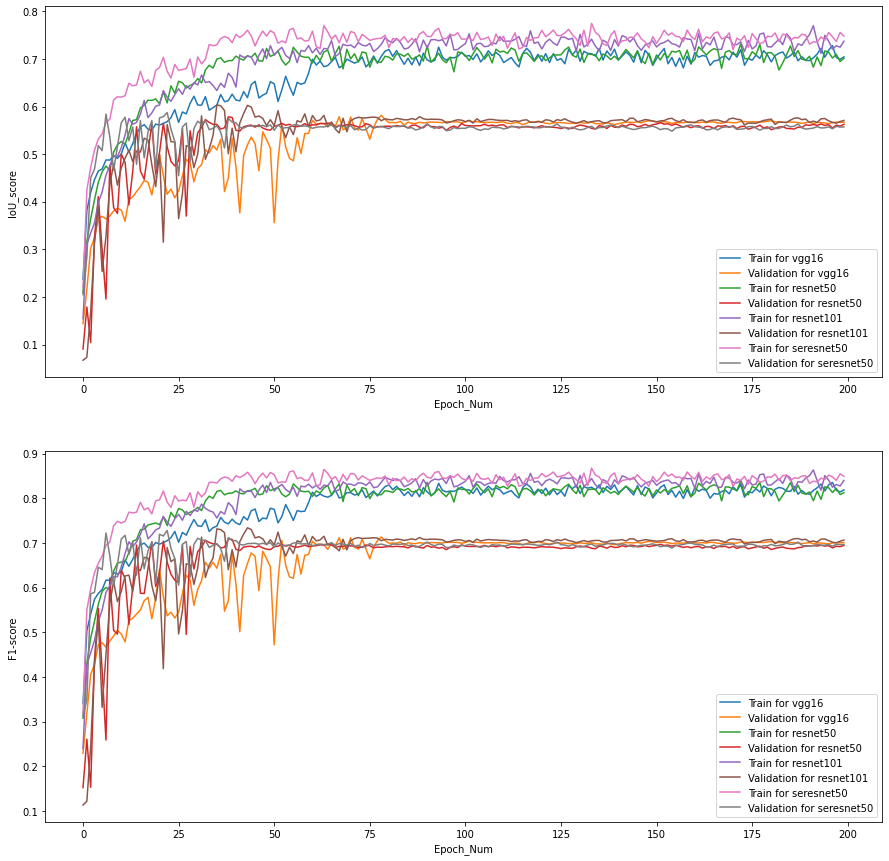

In [12]:

from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from matplotlib import pyplot



def fit_model( BACKBONE):
  BATCH_SIZE = 2
  CLASSES = ['oc']
  EPOCHS = 200
  preprocess_input = sm.get_preprocessing(BACKBONE)
  n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
  activation = 'sigmoid' if n_classes == 1 else 'softmax'

  #create model
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

  # define optomizer
  optim = keras.optimizers.RMSprop(lr=0.0001)
  # Segmentation models losses can be combined together by '+' and scaled by integer or float factor
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5)]

  # compile keras model with defined optimozer, loss and metrics
  model.compile(optim, total_loss, metrics)

  # Dataset for train images
  train_dataset = Dataset(
      x_train_dir, 
      y_train_dir, 
      classes=CLASSES, 
      augmentation=get_training_augmentation(),
      preprocessing=get_preprocessing(preprocess_input),
      )
  
  # Dataset for validation images
  valid_dataset = Dataset(
      x_valid_dir, 
      y_valid_dir, 
      classes=CLASSES, 
      augmentation=get_validation_augmentation(),
      preprocessing=get_preprocessing(preprocess_input),
      )
  
  train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
  # check shapes for errors
  assert train_dataloader[0][0].shape == (BATCH_SIZE, 224, 224, 3)
  assert train_dataloader[0][1].shape == (BATCH_SIZE, 224, 224, n_classes)

  # define callbacks for learning rate scheduling and best checkpoints saving
  callbacks = [
               keras.callbacks.ModelCheckpoint('./best_model_cup1.h5', save_weights_only=True, save_best_only=True, mode='min'),
               keras.callbacks.ReduceLROnPlateau(),
               ]
               
  history = model.fit_generator(
      train_dataloader, 
      steps_per_epoch=len(train_dataloader), 
      epochs=EPOCHS, 
      callbacks=callbacks, 
      validation_data=valid_dataloader, 
      validation_steps=len(valid_dataloader),
      )
  
  plt.subplot(211)
  pyplot.plot(history.history['iou_score'], label='Train for '+str(BACKBONE))
  pyplot.plot(history.history['val_iou_score'], label='Validation for '+str(BACKBONE))
  plt.ylabel('IoU_score')
  plt.xlabel('Epoch_Num')
  plt.legend(loc='lower right')

  plt.subplot(212)
  plt.plot(history.history['f1-score'], label='Train for '+str(BACKBONE))
  plt.plot(history.history['val_f1-score'], label='Validation for '+str(BACKBONE))
  plt.ylabel('F1-score')
  plt.xlabel('Epoch_Num')
  plt.legend(loc='lower right')

plt.figure(figsize=(15, 15))
BACKBONE = ['vgg16','resnet50','resnet101', 'seresnet50']

for i in range(len(BACKBONE)):
  # fit model and plot learning curves for Backbones
  fit_model(BACKBONE[i])

pyplot.show()